## TrumpWorld - analysing companies by country

I'll try to cross-reference the TrumpWorld dataset (specifically, the org-org one) with OpenCorporates.com to gather as much national data as possible for these companies and attribute them a country.

In [237]:
%matplotlib notebook

In [238]:
import sys
import json
import requests
import urllib2 as url
import pandas as pd
import numpy as np
import networkx as nx
from difflib import SequenceMatcher

In [2]:
# First step is loading the .csv and gathering all unique company names
tw_orgorg = pd.read_csv('https://query.data.world/s/94g9v4tj3pzz3ir495y8s3esl')
tw_perorg = pd.read_csv('https://query.data.world/s/50ivsaqkos6vzdf4m51ntq7qc')

In [209]:
# Now we load the OpenCorporates raw data
oc_raw_data = json.load(open('org_OCdata.json'))

In [210]:
# Problem: some entries won't have any results, some will have multiple ones, so we need to purge them
oc_data = {org: oc_raw_data[org] for org in oc_raw_data if len(oc_raw_data[org]) > 1}

print "Results existing for {0} organizations out of {1}".format(len(oc_data), len(oc_raw_data))
missing_orgs = set(oc_raw_data.keys())-set(oc_data.keys())

Results existing for 850 organizations out of 1608


In [211]:
# How many of these have info?
tot = 0
addr = 0
jdc = 0
sdate = 0

for org in oc_data:
    for o in oc_data[org]:
        tot += 1
        addr += o['company']['registered_address'] is not None
        jdc += o['company']['jurisdiction_code'] is not None
        sdate += o['company']['created_at'] is not None
    
print "Addresses: {0}/{1}".format(addr, tot)
print "Jurisdiction codes: {0}/{1}".format(jdc, tot)
print "Creation dates: {0}/{1}".format(sdate, tot)

Addresses: 6262/10261
Jurisdiction codes: 10261/10261
Creation dates: 10261/10261


In [219]:
# Now for the ones with multiple results
org_alive = {}
org_dead = {}
    
for org in oc_data:
    orgs = oc_data[org]
    # First, remove all the dissolved ones
    dead_orgs = [o for o in orgs if o['company']['dissolution_date'] is not None]
    if len(dead_orgs) > 0:
        org_dead[org] = dead_orgs
    orgs = [o for o in orgs if o['company']['dissolution_date'] is None]
    if len(orgs) == 0:
        continue
    # Still not only one? Look for the one whose name matches best!
    matches = np.array([SequenceMatcher(None, org, o['company']['name']).ratio() for o in orgs])
    best_match = np.amax(matches)
    # Is there only one?
    match_i = np.where(np.isclose(matches, best_match))[0]
    # If there's multiple ones, no helping it, we keep 'em all
    org_alive[org] = np.array(orgs)[match_i]

print "Good match(es) found for {0} organizations still existing".format(len(org_alive))

Good match(es) found for 848 organizations still existing


In [213]:
from datetime import datetime as dt
# Time parsing 
date_fmt = '%Y-%m-%dT%H:%M:%S+00:00'

In [221]:
# Now to try and extract country, time of foundation, and jurisdiction code for each of these
# When in doubt, pick the newest one
org_table = []

for org in org_alive:
    orgs = org_alive[org]
    # Columns: organization, country, confidence of country, time of foundation, jurisdiction code
    org_row = [org]
    # Remove organizations without address info, sort by creation date
    orgs = sorted(orgs, key=lambda o: dt.strptime(o['company']['created_at'], dateparse))        
    # Countries?
    countries = [(i, o['company']['registered_address']['country']) for i, o in enumerate(orgs) if o['company']['registered_address'] is not None]
    # How many?
    if len(countries) == 0:
        org_row += ['N/A', 0.0]
        ci = -1
    elif len(countries) == 1:
        org_row += [countries[0][1], 1.0/len(orgs)]
        ci = countries[0][0]
    else:
        ccount = np.array([countries.count(c) for c in countries])
        cmax = np.amax(ccount)
        ci = np.where(ccount == cmax)[0][-1]        
        org_row += [countries[ci][1], cmax*1.0/len(orgs)]
    # Time and jurisdiction
    org_row += [dt.strptime(orgs[ci]['company']['created_at'],
                                     dateparse),
                orgs[ci]['company']['jurisdiction_code']]
    org_table.append(org_row)

In [235]:
# Ok, so store this info in a database
org_dframe = pd.DataFrame(org_table, columns=['Name', 'Country', 'CountryConfidence', 'CreationDate', 'Jurisdiction'])
org_dframe.to_csv('org_country.csv', encoding='utf-8')

### Analysis

Here's the N topmost occurring jurisdictions

<IPython.core.display.Javascript object>


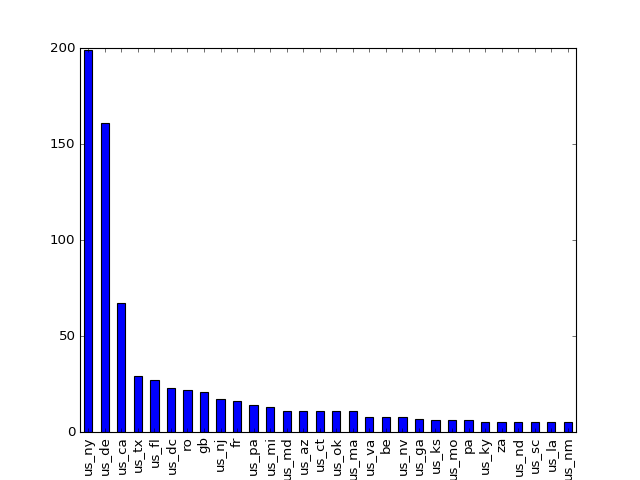

In [245]:
N = 30
org_dframe['Jurisdiction'].value_counts()[:N].plot(kind='bar')

In [248]:
# Some special cases
org_dframe[org_dframe['Jurisdiction'] == 'sa']

,Name,Country,CountryConfidence,CreationDate,Jurisdiction


In [78]:


holdings_graph = nx.Graph()
# Add a special node, Donald J. Trump
holdings_graph.add_node('DONALD J. TRUMP')
# Add all organizations as nodes
holdings_graph.add_nodes_from(org_uni)
# Now connections. First, direct Donald-to-organization ones
for o in tw_perorg[tw_perorg.Person == 'DONALD J. TRUMP'].Organization:
    holdings_graph.add_edge('DONALD J. TRUMP', o)
# Then between organizations
for oa, ob in zip(tw_orgorg['Organization A'], tw_orgorg['Organization B']):
    holdings_graph.add_edge(oa, ob)

In [80]:
# Now compute distances
dist_table = {}

for ou in org_uni:
    try:
        dist = nx.shortest_path_length(holdings_graph, 'DONALD J. TRUMP', ou)
    except nx.NetworkXNoPath:
        dist = None
    dist_table[ou] = dist